In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [57]:
def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

In [60]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
#setting directory to access the files
%cd drive/MyDrive/project\ 3

[Errno 2] No such file or directory: 'drive/MyDrive/project 3'
/content/drive/MyDrive/project 3


In [62]:
#TASK 2

In [63]:
#Creating Lists
Activity = ["walking","running","climbingup","climbingdown"]
Subject = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
Axis = ["x","y","z"]
Dimension =[3,4,5,6]
Delay = [1,2,3]
Signal = [2024,3048,5096]

In [64]:
#Creating empty dataframe with colnames
Col_Names = ["Subject","Accelerometer Axis","Signal Length","Dimension","Delay","Permutation Entropy","Complexity","Activity"]
df_task2=pd.DataFrame(columns=Col_Names)

In [65]:
#for loop to access files for each subjects and append the data to dataframe
for S in Subject:
  for A in Activity:
    Filename = "acc_"+A+"_chest_p"+S+".csv"
    df = pd.read_csv(Filename)
    for a in Axis:
      for s in Signal:
        for D in Dimension:
          for d in Delay:
            op = ordinal_patterns(df["attr_"+a][1000:s],D,d)
            temp3 ={"Subject":S,"Accelerometer Axis":a,"Signal Length":s-1000,
            "Dimension":D,"Delay":d,"Permutation Entropy":p_entropy(op),"Complexity":complexity(op),"Activity":A}
            df_task2 = df_task2.append(temp3, ignore_index=True)


In [66]:
df_task2

,Subject,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity
0,1,x,1024,3,1,0.835931,0.133484,walking
1,1,x,1024,3,2,0.961684,0.035722,walking
2,1,x,1024,3,3,0.986747,0.012778,walking
3,1,x,1024,4,1,0.766084,0.226196,walking
4,1,x,1024,4,2,0.930962,0.087301,walking
...,...,...,...,...,...,...,...,...
6475,15,z,4096,5,2,0.930706,0.113544,climbingdown
6476,15,z,4096,5,3,0.967699,0.058693,climbingdown
6477,15,z,4096,6,1,0.838598,0.246194,climbingdown
6478,15,z,4096,6,2,0.930259,0.145734,climbingdown


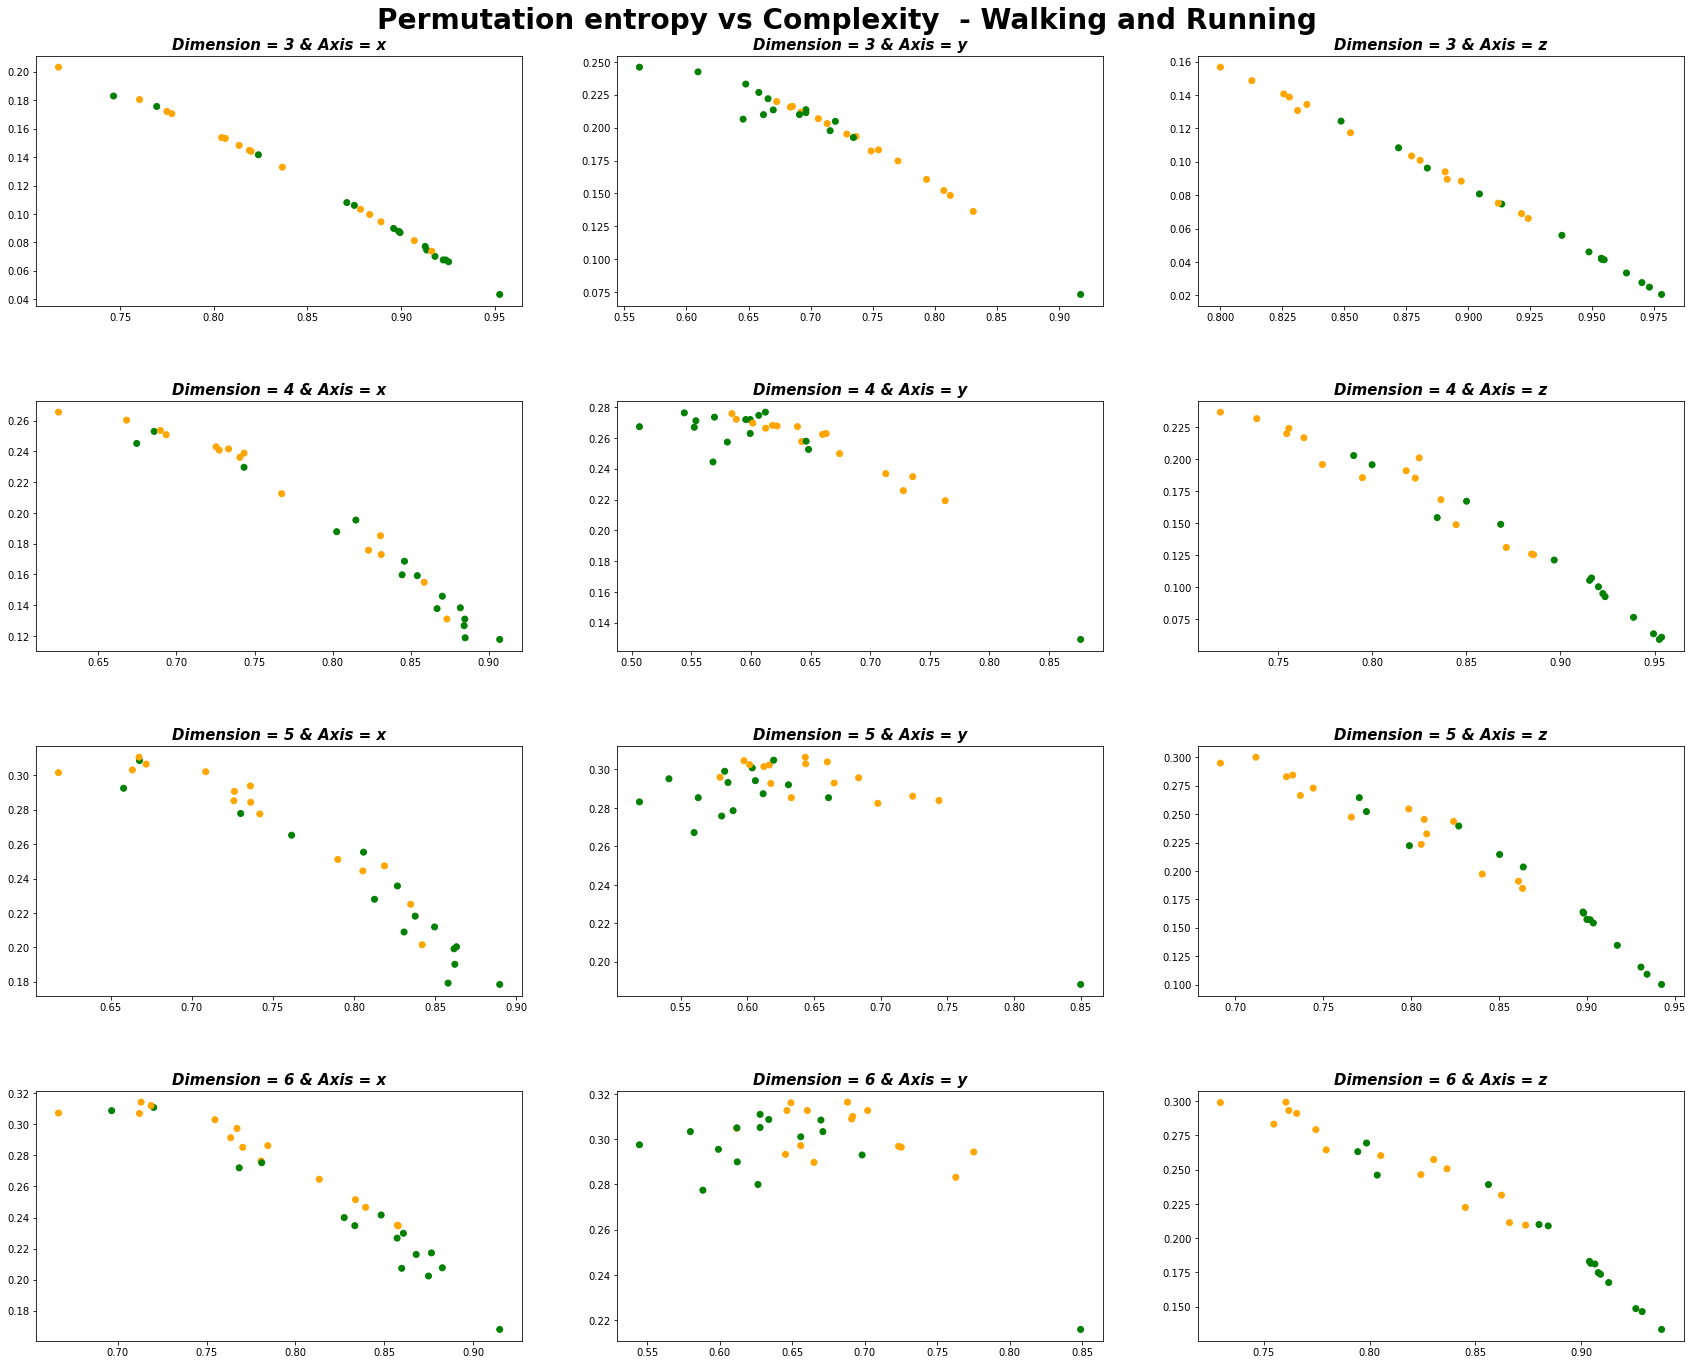

In [67]:
#Scatterplots for Walking and Running
#Creating subplots and title
plot,axis = plt.subplots(4,3,figsize=(25,20))
plot.suptitle("Permutation entropy vs Complexity  - Walking and Running",size=28, weight="bold", color="black")


#Colors for different activities
color={"walking":"orange","running":"green"}

#Plot1
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[0,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,0].set_title('Dimension = 3 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot2
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[0,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,1].set_title('Dimension = 3 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot3
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[0,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,2].set_title('Dimension = 3 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot4
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[1,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,0].set_title('Dimension = 4 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot5
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[1,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,1].set_title('Dimension = 4 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot6
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[1,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,2].set_title('Dimension = 4 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot7
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[2,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,0].set_title('Dimension = 5 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot8
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[2,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,1].set_title('Dimension = 5 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot9
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[2,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,2].set_title('Dimension = 5 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot10
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[3,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,0].set_title('Dimension = 6 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot11
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[3,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,1].set_title('Dimension = 6 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot12
df=df_task2[((df_task2["Activity"]=="walking")|(df_task2["Activity"]=="running")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[3,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,2].set_title('Dimension = 6 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

plot.tight_layout(pad=6.0)
plot.show()



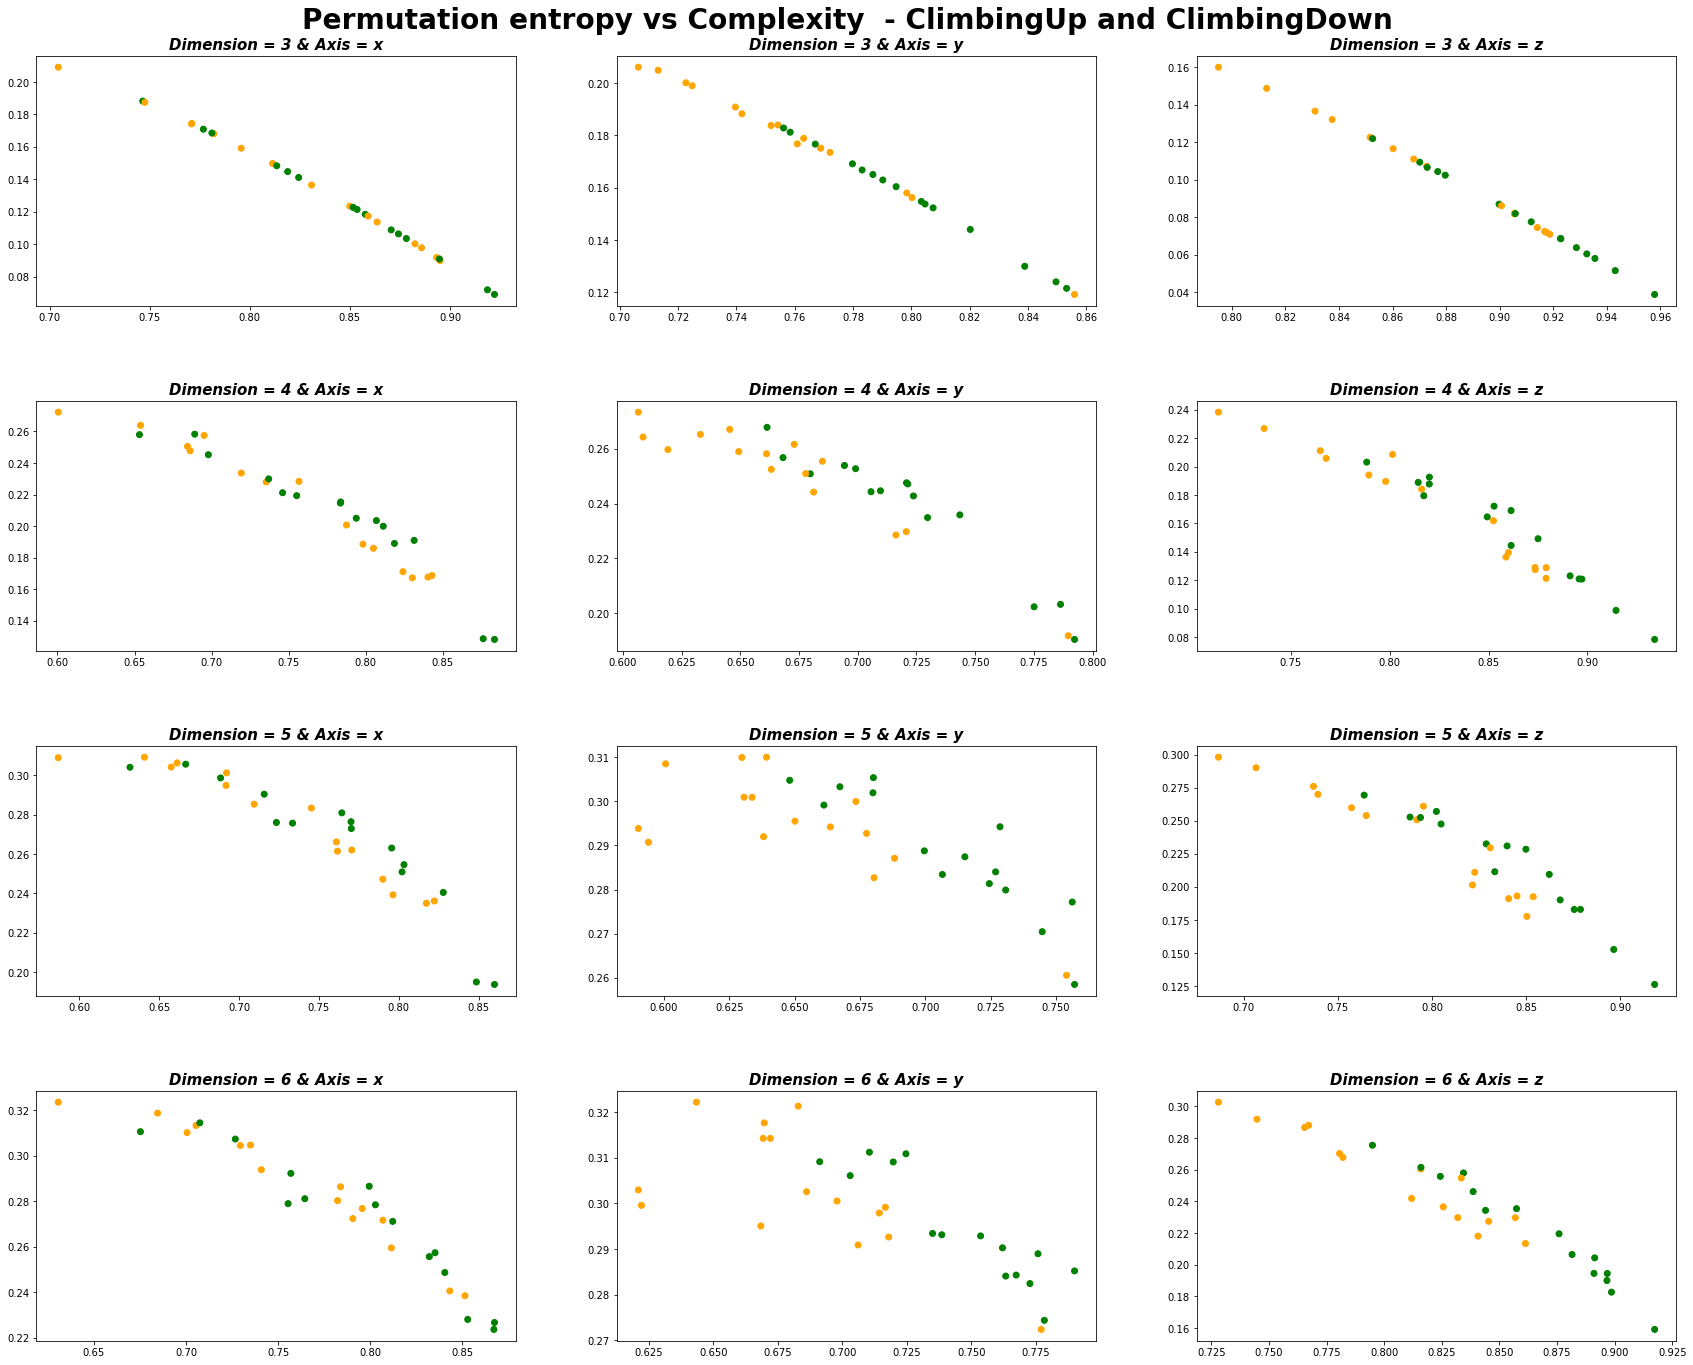

In [68]:
#Scatterplots for ClimbingUp and ClimbingDown
#Creating subplots and title
plot,axis = plt.subplots(4,3,figsize=(25,20))
plot.suptitle("Permutation entropy vs Complexity  - ClimbingUp and ClimbingDown",size=28, weight="bold", color="black")

#Colors for different activities
color={"climbingup":"orange","climbingdown":"green"}

#Plot1
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[0,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,0].set_title('Dimension = 3 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot2
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[0,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,1].set_title('Dimension = 3 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot3
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==3) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[0,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[0,2].set_title('Dimension = 3 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot4
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[1,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,0].set_title('Dimension = 4 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot5
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[1,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,1].set_title('Dimension = 4 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot6
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==4) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[1,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[1,2].set_title('Dimension = 4 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot7
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[2,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,0].set_title('Dimension = 5 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot8
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[2,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,1].set_title('Dimension = 5 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot9
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==5) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[2,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[2,2].set_title('Dimension = 5 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

#Plot10
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="x")]

axis[3,0].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,0].set_title('Dimension = 6 & Axis = x', fontstyle='italic',size=15, weight="bold", color="black")

#Plot11
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="y")]

axis[3,1].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,1].set_title('Dimension = 6 & Axis = y', fontstyle='italic',size=15, weight="bold", color="black")

#Plot12
df=df_task2[((df_task2["Activity"]=="climbingup")|(df_task2["Activity"]=="climbingdown")) &
            (df_task2["Signal Length"]==4096) &
            (df_task2["Delay"]==1) &
            (df_task2["Dimension"]==6) &
            (df_task2["Accelerometer Axis"]=="z")]

axis[3,2].scatter(x=df["Permutation Entropy"],
                  y=df["Complexity"],
                  c=df["Activity"].map(color))
axis[3,2].set_title('Dimension = 6 & Axis = z', fontstyle='italic',size=15, weight="bold", color="black")

plot.tight_layout(pad=6.0)
plot.show()

